## Step 4: Analyze contents and give verdict on importance of reading

In [43]:
import sys
sys.path.append('../')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from components.agents.curator_agent import curate_batch

from data import ContentManager
manager = ContentManager(base_path="../data")

INFO:data.content_manager:Loaded content index with 2484 entries


Get to_pursue items from df

In [49]:
df = pd.read_csv("../data/research_items.csv")

In [50]:
to_curate = df[
    (df["scout_decision"] == "pursue") & 
    (df["content_loaded_locally"] == True) &
    (df["curated_at"].isna() if "curated_at" in df.columns else True)
]

print(f"Curating {len(to_curate)} of {len(df)} items")

Curating 2418 of 4202 items


Build items list with content

In [51]:
items = []
for _, row in to_curate.iterrows():
    content_info = manager.get(row["url"])
    if content_info and "content_path" in content_info:
        content = Path(content_info["content_path"]).read_text()
        items.append({
            "title": row["title"],
            "source": row["source"],
            "url": row["url"],
            "content": content,
        })
    else:
        print(f"No content for {row['url']}")

In [52]:
len(items) == len(to_curate)

True

Run curation

In [ ]:
analyses = await curate_batch(items, batch_size=100)

INFO:components.agents.curator_agent:Processing batch 1/25 (100 items)
Curate batch 1/25:   0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
len(analyses)

15

Update df

In [26]:
url_to_analysis = {items[i]["url"]: analyses[i] for i in range(len(analyses))}

In [38]:
# Update each row
for url, analysis in url_to_analysis.items():
    mask = df["url"] == url
    
    df.loc[mask, "curator_summary"] = analysis.summary
    df.loc[mask, "curator_takeaways"] = "\n- ".join([""] + analysis.key_takeaways)  # list → bullet points
    df.loc[mask, "curator_tags"] = ", ".join(analysis.tags)  # list → comma-separated
    df.loc[mask, "applicability_score"] = analysis.applicability_score
    df.loc[mask, "novelty_score"] = analysis.novelty_score
    df.loc[mask, "priority_score"] = analysis.priority_score
    df.loc[mask, "verdict_reasoning"] = analysis.verdict_reasoning
    df.loc[mask, "curated_at"] = datetime.now().isoformat()

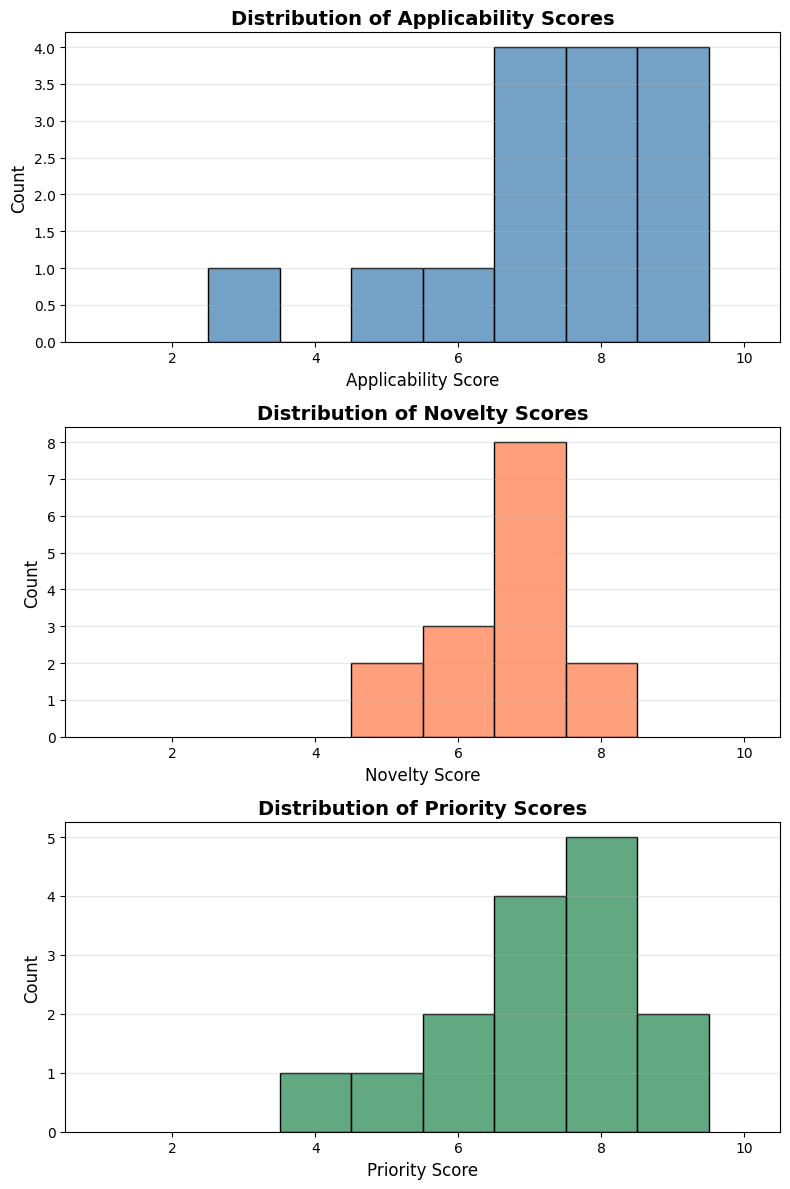

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Applicability Score
sns.histplot(df['applicability_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[0], color='steelblue', discrete=True)
axes[0].set_xlabel('Applicability Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Applicability Scores', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 10.5)
axes[0].grid(axis='y', alpha=0.3)

# Novelty Score
sns.histplot(df['novelty_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[1], color='coral', discrete=True)
axes[1].set_xlabel('Novelty Score', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Novelty Scores', fontsize=14, fontweight='bold')
axes[1].set_xlim(0.5, 10.5)
axes[1].grid(axis='y', alpha=0.3)

# Priority Score
sns.histplot(df['priority_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[2], color='seagreen', discrete=True)
axes[2].set_xlabel('Priority Score', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Distribution of Priority Scores', fontsize=14, fontweight='bold')
axes[2].set_xlim(0.5, 10.5)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save
#df.to_csv("../data/research_items.csv", index=False)
print(f"Updated {len(url_to_analysis)} items")

In [48]:
# Must reads (priority >= 8)
curated = df[df["curated_at"].notna()]
must_reads = curated[curated["priority_score"] >= 8].sort_values(by="priority_score", ascending=False)

print(f"\n🔥 Must reads: {len(must_reads)}")
print(must_reads[["title", "priority_score", "source"]].head(10))


🔥 Must reads: 7
                                                title  priority_score  \
3                                 Introducing GPT-5.2             9.0   
6   anthropics/skills — Agent Skills repository (s...             9.0   
4   Introducing Gemini 3: our most intelligent mod...             8.0   
5   Equipping agents for the real world with Agent...             8.0   
8   The Art of Scaling Test-Time Compute for Large...             8.0   
9   When Does Verification Pay Off? A Closer Look ...             8.0   
12  Budget-Aware Tool-Use Enables Effective Agent ...             8.0   

                           source  
3                     OpenAI blog  
6                          GitHub  
4   Google Blog (Gemini/DeepMind)  
5           Anthropic Engineering  
8                           arXiv  
9                           arXiv  
12                          arXiv  
